In [1]:
import io
import sys
import os
import time
import picamera
import numpy as np
from time import sleep
import time
import matplotlib.pyplot as plt
# from tqdm.auto import tqdm
from tqdm import tqdm_notebook as tqdm
from astropy.io import fits
from instrumental import instrument, list_instruments, u

In [2]:
path = "/media/pi/TOLIMAN-1/data"
os.chdir(path)

In [3]:
devices = list_instruments()
[device for  device in devices]
instruments = [instrument(device) for device in devices]
z = instruments[0]
y = instruments[1]
x = instruments[2]

In [4]:
print(devices)

[<ParamSet[TDC001_APT] port='/dev/ttyUSB2'>, <ParamSet[TDC001_APT] port='/dev/ttyUSB1'>, <ParamSet[TDC001_APT] port='/dev/ttyUSB0'>]


In [5]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [6]:
def move(axis, dist, cen):
    pos = cen + dist/1000
    with HiddenPrints():
        axis.move_to(pos*u.mm)

In [7]:
def get_rgb_new(stream):
    
    offset = 10270208
    data = stream.getvalue()[-offset:]
    data = data[32768:]
    data = np.frombuffer(data, dtype=np.uint8)

    reshape_val = (2480, 4128)
    crop = (2464, 4100)
    data = data.reshape(reshape_val)[:crop[0], :crop[1]]

    data = data.astype(np.uint16) << 2
    for byte in range(4):
        data[:, byte::5] |= ((data[:, 4::5] >> ((4 - byte) * 2)) & 0b11)
    data_array = np.delete(data, np.s_[4::5], 1)
    
    # RGGB
    array_out = np.array([data_array[1::2, 1::2], data_array[1::2, 0::2], data_array[0::2, 1::2], data_array[0::2, 0::2]])    
    return array_out

In [8]:
def take_im(c, file_string, header):
    stream = io.BytesIO()
    c.capture(stream, format='jpeg', bayer=True)
    rgb = get_rgb_new(stream)
#     fits.PrimaryHDU(rgb).writeto(file_string, rgb, header=header)
    fits.writeto(file_string, rgb, header=header)
    stream.flush()
    stream.close()
    del stream

In [9]:
def get_im(c):
    stream = io.BytesIO()
    c.capture(stream, format='jpeg', bayer=True)
    rgb = get_rgb_new(stream)
    stream.flush()
    stream.close()
    del stream
    return rgb

In [68]:
xmin = 0.058
xmax = xmin + 5.2
cx = xmin + (xmax-xmin)/2

ymin = 2.235
ymax = ymin + 3.90
cy = (ymax+ymin)/2

In [69]:
move(x, 0, cx)
move(y, 0, cy)

In [78]:
x_res = 3280//2
y_res = 2464//2
sub_dir = "test"

with picamera.PiCamera() as c:
    
    # Initialise camera values 
    c.brightness = 50
    c.contrast = 0
    c.exposure_compensation = 0
    c.saturation = 0
    c.sharpness = 0
    c.exposure_mode = "off"
    c.awb_mode = "off"
    c.image_denoise = False
    c.resolution = (x_res, y_res)

    # Set frame rate to that determined from above
    c.framerate = 10
    c.shutter_speed = 10000

    # Get file names
    file_names = os.listdir(path + "/{}".format(sub_dir))
    
    # Get first available string name
    im_num = 0
    test_string = "test_{}.fits".format(im_num)
    while test_string in file_names:
        im_num += 1
        test_string = "test_{}.fits".format(im_num)
    file_name = path + "/{}/".format(sub_dir) + test_string  
    
    # Generate header data
    T = time.localtime() # Get date and time
    header = fits.Header()
    header["NAXIS"] = 3
    header["NAXIS1"] = x_res
    header["NAXIS2"] = y_res
    header["NAXIS3"] = 4 # RGGB
    header["DATE"] = "{}-{}-{}".format(T.tm_mday, T.tm_mon, T.tm_year)
    header["TIME"] = "{}:{}:{}".format(T.tm_hour, T.tm_min, T.tm_sec)
    header["SSPEED"] = c.shutter_speed
    header["FRATE"] = c.framerate.numerator/c.framerate._denominator
    
    # Take image
    take_im(c, file_name, header)
    
im = fits.open(file_name)[0].data

In [79]:
header = fits.getheader(file_name)
for key in header.keys():
        print(key, header[key])

SIMPLE True
BITPIX 16
NAXIS 3
NAXIS1 1640
NAXIS2 1232
NAXIS3 4
DATE 21-11-2019
TIME 10:40:39
SSPEED 9991
FRATE 10.0
BSCALE 1
BZERO 32768


In [80]:
c1 = im.shape[1]//2 # x centre
c2 = im.shape[2]//2 # y centre
s1 = 200 # Central size
s2 = 300 # Corner size
off = (x_res-y_res)//2 #offset
order = ["Red", "Green 1", "Green 2", "Blue"]

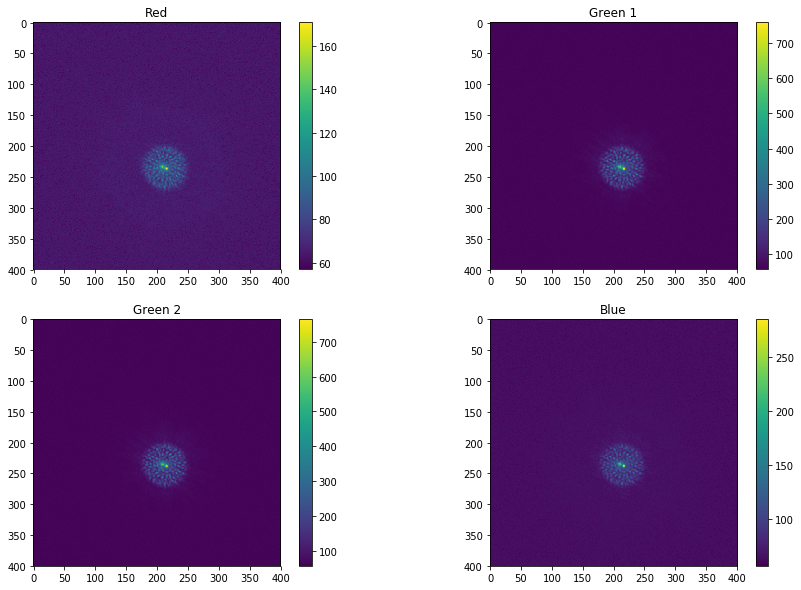

In [81]:
fig = plt.figure(figsize=(15,10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title("{}".format(order[i]))
    plt.imshow(im[i][c1-s1:c1+s1, c2-s1:c2+s1])
    plt.colorbar()
    
plt.show()

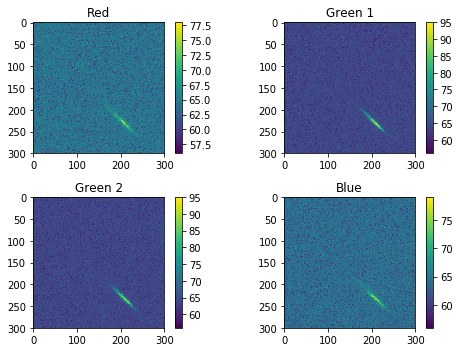

In [82]:
fig = plt.figure(figsize=(7,5))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title("{}".format(order[i]))
    plt.imshow(im[i][0:s2, off:s2+off])
    plt.colorbar()
    
plt.tight_layout()
plt.show()

---
# ADD LIGHT SOURCE HERE

In [83]:
light_source = "530_530/run_2"

In [86]:
phis = np.linspace(0, 2*np.pi, endpoint=False, num=16)
rs = np.linspace(50, 250, num=51)
shutter_speeds = np.linspace(10000, 15000, 6)

In [87]:
print(rs)
print()
print(phis/(np.pi))
print()
print(shutter_speeds)

[ 50.  54.  58.  62.  66.  70.  74.  78.  82.  86.  90.  94.  98. 102.
 106. 110. 114. 118. 122. 126. 130. 134. 138. 142. 146. 150. 154. 158.
 162. 166. 170. 174. 178. 182. 186. 190. 194. 198. 202. 206. 210. 214.
 218. 222. 226. 230. 234. 238. 242. 246. 250.]

[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.    1.125 1.25  1.375
 1.5   1.625 1.75  1.875]

[10000. 11000. 12000. 13000. 14000. 15000.]


In [88]:
num_frames = 5

## Take nulls

In [91]:
x_res = 3280//2
y_res = 2464//2
sub_dir = "{}/nulls".format(light_source)

with picamera.PiCamera() as c:
    
    # Initialise camera values 
    c.brightness = 50
    c.contrast = 0
    c.exposure_compensation = 0
    c.saturation = 0
    c.sharpness = 0
    c.exposure_mode = "off"
    c.awb_mode = "off"
    c.image_denoise = False
    c.resolution = (x_res, y_res)

    # Set frame rate to that determined from above
    c.framerate = 10
    
    for shutter_speed in tqdm(shutter_speeds):
        c.shutter_speed = int(shutter_speed)

        for idx in range(num_frames):
            test_string = "null_{}_{}.fits".format(idx, c.shutter_speed)
            file_name = path + "/{}/".format(sub_dir) + test_string  

            # Generate header data
            T = time.localtime() # Get date and time
            header = fits.Header()
            header["NAXIS"] = 3
            header["NAXIS1"] = x_res
            header["NAXIS2"] = y_res
            header["NAXIS3"] = 4 # RGGB
            header["DATE"] = "{}-{}-{}".format(T.tm_mday, T.tm_mon, T.tm_year)
            header["TIME"] = "{}:{}:{}".format(T.tm_hour, T.tm_min, T.tm_sec)
            header["SPEEDSET"] = shutter_speed
            header["SSPEED"] = c.shutter_speed
            header["FRATE"] = c.framerate.numerator/c.framerate._denominator

            # Take image
            take_im(c, file_name, header)

## Take data

In [ ]:
x_res = 3280//2
y_res = 2464//2
sub_dir = "{}/data".format(light_source)

with picamera.PiCamera() as c:
    
    # Initialise camera values 
    c.brightness = 50
    c.contrast = 0
    c.exposure_compensation = 0
    c.saturation = 0
    c.sharpness = 0
    c.exposure_mode = "off"
    c.awb_mode = "off"
    c.image_denoise = False
    c.resolution = (x_res, y_res)

    # Set frame rate to that determined from above
    c.framerate = 10
#     c.shutter_speed = 20000
    
    idx = 0
    epoch = 0
    
    for shutter_speed in tqdm(shutter_speeds):
        c.shutter_speed = int(shutter_speed)

        move(x, 0, cx)
        move(y, 0, cy)
        sleep(5)

        for r in rs:
            for phi in phis:
                X = r*np.cos(phi)
                Y = r*np.sin(phi)

                # Move to new position and give time to get there
                move(x, X, cx)
                move(y, Y, cy)
                sleep(2)

                for i in range(num_frames):
                    test_string = "image_{}_{}.fits".format(epoch, idx)
                    file_name = path + "/{}/".format(sub_dir) + test_string  

                    # Generate header data
                    T = time.localtime() # Get date and time
                    header = fits.Header()
                    header["NAXIS"] = 3
                    header["NAXIS1"] = x_res
                    header["NAXIS2"] = y_res
                    header["NAXIS3"] = 4 # RGGB
                    header["DATE"] = "{}-{}-{}".format(T.tm_mday, T.tm_mon, T.tm_year)
                    header["TIME"] = "{}:{}:{}".format(T.tm_hour, T.tm_min, T.tm_sec)
                    header["SSPEED"] = c.shutter_speed
                    header["SPEEDSET"] = int(shutter_speed)
                    header["FRATE"] = c.framerate.numerator/c.framerate._denominator
                    header["R"] = r
                    header["PHI"] = phi
                    header["XPOS"] = X
                    header["YPOS"] = Y
                    header["EPOCH"] = epoch
                    header["IDX"] = idx
                    header["IM_NUM"]  = i

                    # Take image
                    take_im(c, file_name, header)

                    idx += 1

In [34]:
print(epoch)

1
